In [174]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_dir = "data/"

In [175]:
df = pd.read_csv(data_dir + "predicting_food_crises_data.csv")
df = df[df["country"] == "South Sudan"]
df["date"] = pd.to_datetime(df["year_month"], format="%Y_%m")

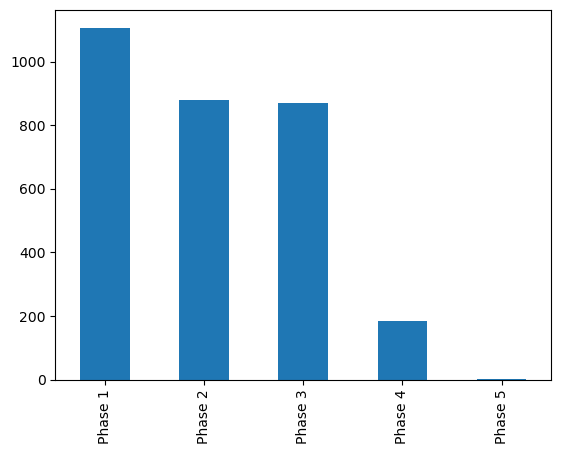

In [176]:
ax = df["fews_ipc"].value_counts().plot(kind="bar")
ax.set_xticklabels(["Phase {}".format(i) for i in range(1, 6)])

<AxesSubplot: >

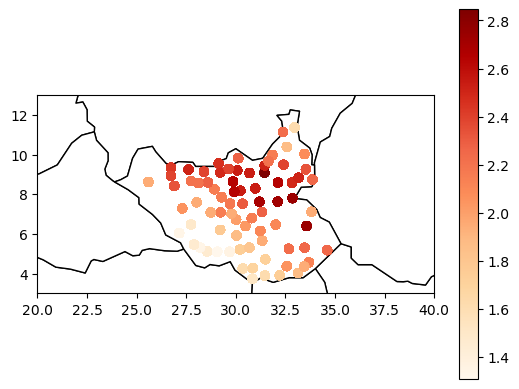

In [177]:
# plot map of south sudan
# first, get map of the world
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
# plot world map
ax = world.plot(color="white", edgecolor="black")
# bound to south sudan
ax.set_xlim(20, 40)
ax.set_ylim(3, 13)

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["centx"], df["centy"]))
mean_ipc = (
    df[["fews_ipc", "admin_name"]]
    .groupby("admin_name")
    .mean()
    .rename(columns={"fews_ipc": "mean_ipc"})
)
gdf.merge(mean_ipc, on="admin_name").plot(
    column="mean_ipc", ax=ax, legend=True, cmap="OrRd"
)

In [178]:
df_panel = df.set_index(["date", "admin_name"])["fews_ipc"].unstack()
# drop rows with all NaNs
df_panel = df_panel.dropna(how="any")

In [179]:
df_panel_lag = df_panel.shift(1)
df_panel_lag2 = df_panel.shift(2)
df_panel_lag3 = df_panel.shift(3)

In [180]:
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

X = pd.DataFrame(df_panel_lag.unstack()).rename(columns={0: "lag1"})
X["lag2"] = df_panel_lag2.unstack()
X["lag3"] = df_panel_lag3.unstack()
X = X.join(df.set_index(["date", "admin_name"])["ndvi_anom"])
X = X.join(df.set_index(["date", "admin_name"])["acled_count"])


staple_prices = df.set_index(["date", "admin_name"])["p_staple_food"].unstack()
# take first difference
staple_prices_diff = staple_prices.diff()
# stack
staple_prices_diff = staple_prices_diff.stack().rename("staple_prices_diff")

X = X.join(staple_prices_diff)


X = sm.add_constant(X)
y = df_panel.unstack()

cutoff = pd.to_datetime("2017-01-01")
X_train = X[X.index.get_level_values(1) < cutoff]
X_test = X[X.index.get_level_values(1) >= cutoff]
y_train = y[y.index.get_level_values(1) < cutoff]
y_test = y[y.index.get_level_values(1) >= cutoff]


model = OLS(y_train, X_train, missing="drop")
results = model.fit()
print(results.summary())

# run model on test data
y_pred = results.predict(X_test)
# print mae
print(f"MAE: {(y_pred - y_test).abs().mean().mean():.2f}")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     338.6
Date:                Mon, 05 Jun 2023   Prob (F-statistic):          5.82e-301
Time:                        08:13:42   Log-Likelihood:                -1671.7
No. Observations:                2028   AIC:                             3357.
Df Residuals:                    2021   BIC:                             3397.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.6734      0

Predicted  2.0  3.0  4.0  5.0
Actual                       
2.0         67   59    0    0
3.0         88  389   43    3
4.0          5   90   35    0
5.0          0    0    1    0


<AxesSubplot: xlabel='Predicted', ylabel='Actual'>

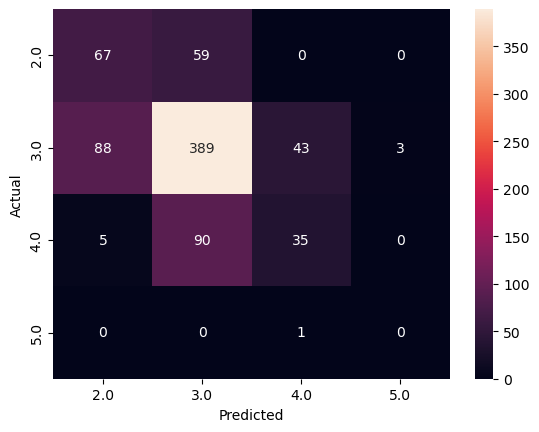

In [181]:
# make confusion matrix
y_pred = y_pred.round()
y_test = y_test.round()
confusion_matrix = pd.crosstab(
    y_test, y_pred, rownames=["Actual"], colnames=["Predicted"]
)
print(confusion_matrix)

sns.heatmap(confusion_matrix, annot=True, fmt="g")

In [182]:
# lagged IPC
df_panel_lag1 = df_panel.shift(1)

In [183]:
df.drop_duplicates("admin_code")

,country,admin_code,admin_name,centx,centy,year_month,year,month,fews_ipc,fews_ha,...,acled_count,acled_fatalities,p_staple_food,area,cropland_pct,pop,ruggedness_mean,pasture_pct,date,geometry
118026,South Sudan,74,Bor South,32.00486,6.465644,2007_01,2007,1,NaN,NaN,...,0,0,0.561363,14008.3300,7.961984,239344.00,11393.760,90.85030,2007-01-01,POINT (32.00486 6.46564)
118184,South Sudan,75,Jur River,28.02439,7.592506,2007_01,2007,1,NaN,NaN,...,0,0,0.627138,10091.0400,0.157174,139593.20,3157.810,85.95082,2007-01-01,POINT (28.02439 7.59251)
118342,South Sudan,76,Aweil North,26.72969,9.334756,2007_01,2007,1,NaN,NaN,...,0,0,0.598097,6369.0120,22.906570,146637.60,4808.697,93.45946,2007-01-01,POINT (26.72969 9.33476)
118500,South Sudan,77,Morobo,30.83354,3.737241,2007_01,2007,1,NaN,NaN,...,0,0,0.675463,1350.3260,11.325100,112702.30,129546.200,58.31250,2007-01-01,POINT (30.83354 3.73724)
118658,South Sudan,78,Magwi,32.21030,3.910535,2007_01,2007,1,NaN,NaN,...,3,13,0.643859,5174.6130,38.886430,175006.60,60845.230,71.81667,2007-01-01,POINT (32.21030 3.91053)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129560,South Sudan,147,Fashoda,31.84424,9.980295,2007_01,2007,1,NaN,NaN,...,0,0,0.501935,3609.4460,18.379110,40665.38,20706.260,83.44186,2007-01-01,POINT (31.84424 9.98029)
129718,South Sudan,148,Manyo,32.37020,11.130980,2007_01,2007,1,NaN,NaN,...,0,0,0.576006,6705.8790,19.518040,47421.98,15857.510,65.76316,2007-01-01,POINT (32.37020 11.13098)
129876,South Sudan,149,Melut,32.56855,10.380960,2007_01,2007,1,NaN,NaN,...,0,0,0.555876,6969.6790,36.065690,53314.57,15045.450,76.70732,2007-01-01,POINT (32.56855 10.38096)
130034,South Sudan,150,Renk,32.95721,11.362640,2007_01,2007,1,NaN,NaN,...,0,0,0.585592,10070.0700,42.586870,149185.90,13703.640,63.24167,2007-01-01,POINT (32.95721 11.36264)


In [184]:
# csv
news_df = pd.read_csv(data_dir + "articles_topics.csv")
news_df["date"] = pd.to_datetime(
    pd.to_datetime(news_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)
# to geodataframe
news_df = gpd.GeoDataFrame(
    news_df, geometry=gpd.points_from_xy(news_df["lng"], news_df["lat"])
)

# df to geodataframe
small_df = df.drop_duplicates("admin_name")
gdf = gpd.GeoDataFrame(
    small_df, geometry=gpd.points_from_xy(small_df["centx"], small_df["centy"])
)
gdf = gdf[["geometry", "admin_name"]]

# sjoin nearest with gdf and news_df
gdf = gpd.sjoin_nearest(news_df, gdf, how="left")

In [186]:
hunger = gdf.groupby(["date"])["hunger"].mean()
# fill na with 0
hunger = hunger.fillna(0)
# rolling mean
hunger = hunger.rolling(3).mean()

# lag by 3 months
hunger = hunger.shift(3)

In [187]:
refugees = gdf.groupby(["date"])["refugees"].mean()
# fill na with 0
refugees = refugees.fillna(0)
# rolling mean
refugees = refugees.rolling(3).mean()

# lag by 3 months
refugees = refugees.shift(3)

In [188]:
conflict = gdf.groupby(["date"])["conflict"].mean()
# fill na with 0
conflict = conflict.fillna(0)
# rolling mean
conflict = conflict.rolling(3).mean()

# lag by 3 months
conflict = conflict.shift(3)

In [189]:
humanitarian = gdf.groupby(["date"])["humanitarian"].mean()
# fill na with 0
humanitarian = humanitarian.fillna(0)
# rolling mean
humanitarian = humanitarian.rolling(3).mean()

# lag by 3 months
humanitarian = humanitarian.shift(3)

In [190]:
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

X = pd.DataFrame(df_panel_lag.unstack()).rename(columns={0: "lag1"})
X["lag2"] = df_panel_lag2.unstack()
X["lag3"] = df_panel_lag3.unstack()
X = X.join(df.set_index(["date", "admin_name"])["ndvi_anom"])
X = X.join(df.set_index(["date", "admin_name"])["acled_count"])


staple_prices = df.set_index(["date", "admin_name"])["p_staple_food"].unstack()
# take first difference
staple_prices_diff = staple_prices.diff()
# stack
staple_prices_diff = staple_prices_diff.stack().rename("staple_prices_diff")

X = X.join(staple_prices_diff)
X = X.join(hunger)
X = X.join(refugees)
X = X.join(conflict)
X = X.join(humanitarian)


X = sm.add_constant(X)
y = df_panel.unstack()

cutoff = pd.to_datetime("2017-01-01")
X_train = X[X.index.get_level_values(1) < cutoff]
X_test = X[X.index.get_level_values(1) >= cutoff]
y_train = y[y.index.get_level_values(1) < cutoff]
y_test = y[y.index.get_level_values(1) >= cutoff]


model = OLS(y_train, X_train, missing="drop")
results = model.fit()
print(results.summary())

# run model on test data
y_pred = results.predict(X_test)
# print mae
print(f"MAE: {(y_pred - y_test).abs().mean().mean():.2f}")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     182.4
Date:                Mon, 05 Jun 2023   Prob (F-statistic):          3.56e-232
Time:                        08:13:56   Log-Likelihood:                -1228.6
No. Observations:                1482   AIC:                             2477.
Df Residuals:                    1472   BIC:                             2530.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2784      0

Predicted  2.0  3.0  4.0
Actual                  
2.0         83   43    0
3.0        103  396   24
4.0          4  114   12
5.0          0    0    1


<AxesSubplot: xlabel='Predicted', ylabel='Actual'>

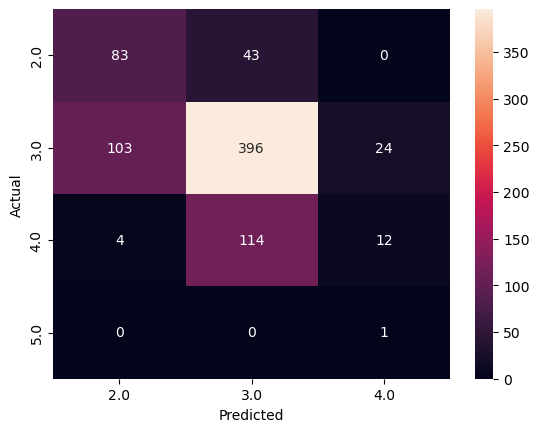

In [191]:
# make confusion matrix
y_pred = y_pred.round()
y_test = y_test.round()
confusion_matrix = pd.crosstab(
    y_test, y_pred, rownames=["Actual"], colnames=["Predicted"]
)
print(confusion_matrix)

sns.heatmap(confusion_matrix, annot=True, fmt="g")

In [192]:
combined = pd.concat([X, y.rename("ipc")], axis=1)

In [203]:
combined = (
    pd.DataFrame(y.rename("ipc"))
    .join(gdf.groupby(["date"])["hunger"].mean())
    .join(gdf.groupby(["date"])["refugees"].mean())
    .join(gdf.groupby(["date"])["conflict"].mean())
    .join(gdf.groupby(["date"])["humanitarian"].mean())
)

<AxesSubplot: xlabel='ipc'>

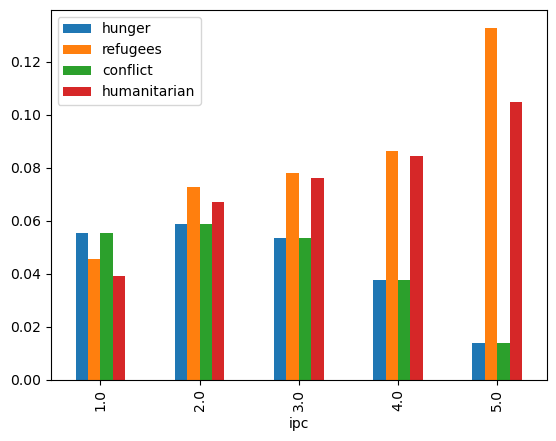

In [204]:
combined.groupby("ipc")[["hunger", "refugees", "conflict", "humanitarian"]].mean().plot(
    kind="bar"
)